### PATHS AND DEPENDENCIES

In [84]:
# Paths
PWD = "/home/hanchau/proj/ds/spinny/"
TRAIN_DATA = "data/house_train.csv"
TEST_DATA = "data/house_test.csv"
import os; os.chdir(PWD)

# Dependencies
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')

# Helpers & Utils
class PreProcess:
    """
        PreProcess: 
        1. Loading data
        2. Dropping unnecessary features
        3. Check nan values
        4. Make custom groups/classes
        5. Check class level aggregates
        6. Nan filling strategy
    """
    def load_data(path):
        ret = pd.read_csv(path)
        print(f"Loaded file: {path}")
        return ret

    def drop_un(df, cols):
        try: 
            ret = df.drop(cols, axis=1)
            print(f"Dropped Columns: {cols}")
            return ret
        except: 
            ret = df.drop(cols[-1], axis=1)
            print(f"Dropped Columns: {cols[-1]}")
            return ret

    def check_nan(df, col):
        ret = df[col].isnull().values.sum()
        print(f"Checking nan in: {col}")
        return ret

    def make_cat(df, col, bins, labels):
        df[col] = pd.cut(df[col], bins=bins, labels=labels)
        print(f"Made custom classes: {labels}")

    def check_agg(df, col):
        ret = pd.DataFrame(df[col].value_counts())
        print(f"Checking counts in: {col}")
        return ret

    def check_agg_all(df):
        ret = []
        for col in df.columns:
            ret.append(pd.DataFrame(df[col].value_counts()))
        print(f"Checking class aggregates of all Columns:", end="\n")
        return ret

    def fill_na(df, col, type='mode'):
        if type=='mode':
            ret = df.fillna({col : df[col].mode()[0]})
        elif type=='mean':
            ret = df.fillna({col : df[col].mean()[0]})
        elif type=='median':
            ret = df.fillna({col : df[col].mean()[0]})
        print(f"Fill NAN strategy: {type}")
        return ret

    def info(df):
        shape = df.shape
        print(f"All features and Null Counts:", end="\n") 
        return df.info()
        print("\n\n\n")
    
    def get_nan(df):
        ret = df.columns[df.isna().any()].tolist()
        print(f"#NAN columns: {len(ret)}, NAN columns: {ret}", end="\n\n") 
        return ret

    def describe(df):
        print(f"Comprehensive aggregate description", end="\n")
        return df.describe(include='all').T

    def describe_missing(df):
        print(f"Aggregate description for Missing", end="\n")
        ret = df.describe(include='all').T
        ret = ret[ret['count'] != 1168]
        print(ret)
        return ret

class EDA:
    """
        EDA: 
        1. Simple plot - distribution
        2. Plot dist of all columns
        3. Plot contingency matrix
        4. 
    """
    def plot_dist(df, col):
        print(f"Ploting columns: {col}", end="\n")
        sns.distplot(df[col])

    def plot_all_dist(df, cols = [], kind = 'box', target = ''):
        print(f"Plotting all features distribution.\nIt may take a while..", end="\n\n")

        skipped_cols = []
        if cols is None: cols = df.columns 

        fig, axes = plt.subplots(len(cols)//3 + 1, 3, figsize=(30, 30))


        for i, col in enumerate(cols):
            try: 
                if kind == 'box':
                    sns.boxplot(ax=axes[i//3, i%3], data=df, x=col, y=target)
                elif kind == 'dist':
                    sns.distplot(ax=axes[i//3, i%3], data=df[col])
                elif kind == 'bar':
                    sns.barplot(ax=axes[i//3, i%3], data=df, x=col, y=target)
            except: skipped_cols.append(col)
        return skipped_cols

# Data loading
data = PreProcess.load_data(TRAIN_DATA)
t_data = PreProcess.load_data(TEST_DATA)

Loaded file: data/house_train.csv
Loaded file: data/house_test.csv


### STUDY FEATURES

In [ ]:
# PreProcess.info(data)
nan_cols = PreProcess.get_nan(data)
desc = PreProcess.describe(data)


In [ ]:
# Categorical or Continueous
agg = PreProcess.check_agg_all(data)
agg

Aggregate description for Missing
               count unique     top  freq        mean         std     min  \
LotFrontage    982.0    NaN     NaN   NaN   70.092668   24.737533    21.0   
Alley             74      2    Grvl    39         NaN         NaN     NaN   
MasVnrType      1161      4    None   696         NaN         NaN     NaN   
MasVnrArea    1161.0    NaN     NaN   NaN  104.009475  181.134311     0.0   
BsmtQual        1135      4      TA   525         NaN         NaN     NaN   
BsmtCond        1135      4      TA  1046         NaN         NaN     NaN   
BsmtExposure    1134      4      No   761         NaN         NaN     NaN   
BsmtFinType1    1135      6     Unf   339         NaN         NaN     NaN   
BsmtFinType2    1135      6     Unf  1005         NaN         NaN     NaN   
FireplaceQu      614      5      Gd   312         NaN         NaN     NaN   
GarageType      1103      6  Attchd   690         NaN         NaN     NaN   
GarageYrBlt   1103.0    NaN     NaN   NaN 

[]

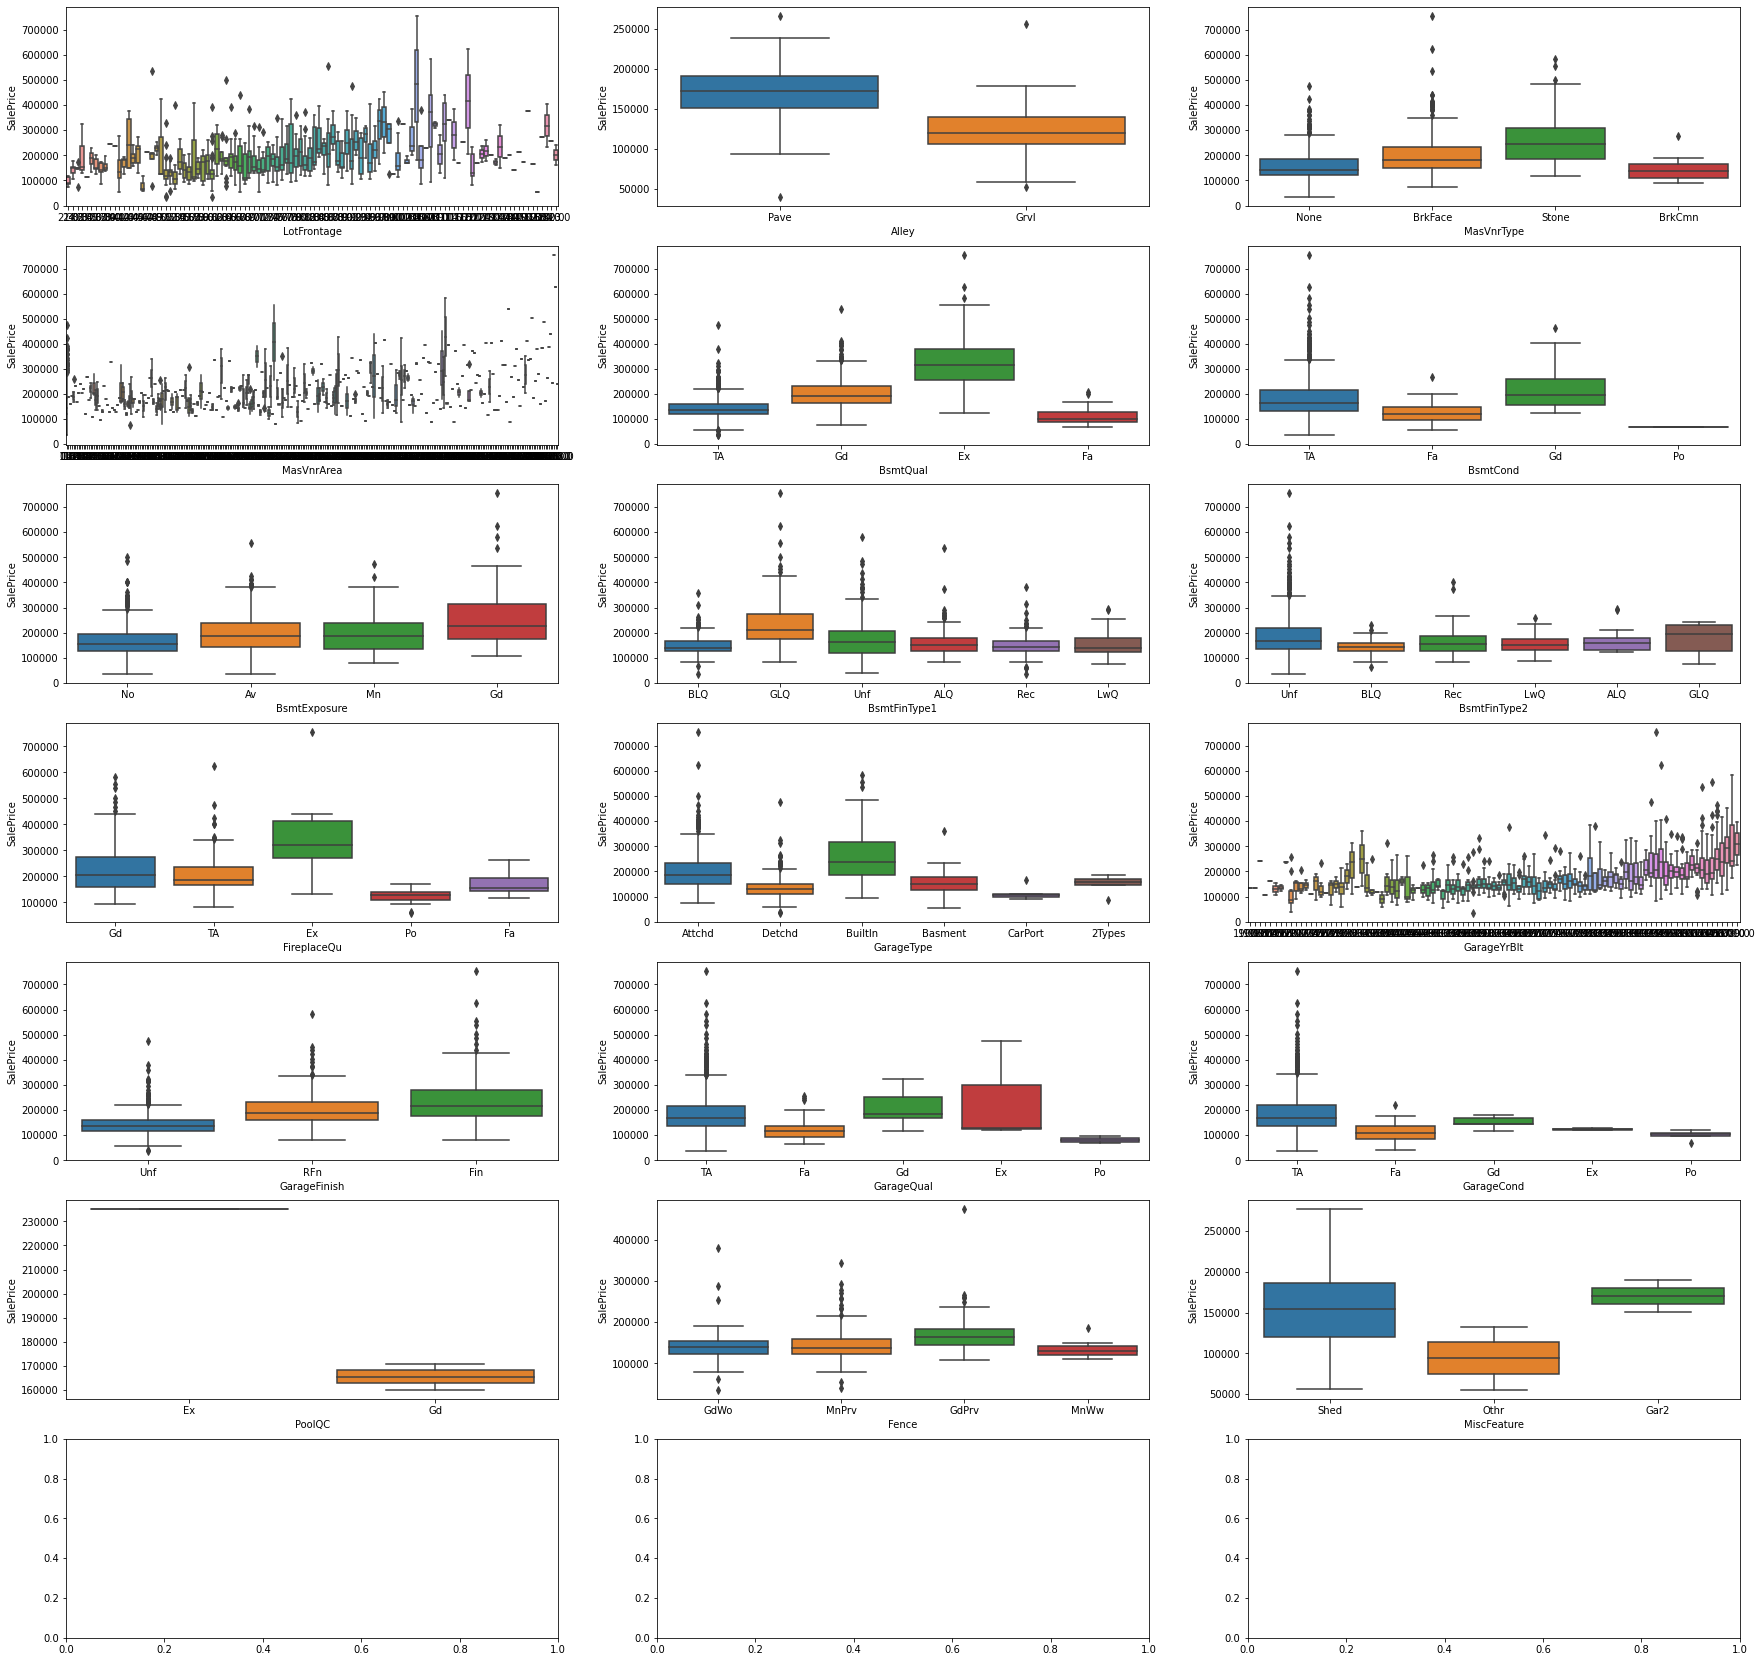

In [85]:
# Preparing for custom classes for continueous
# desc = PreProcess.describe(data)
desc = PreProcess.describe_missing(data)
EDA.plot_all_dist(data, cols = desc.T.columns, kind = 'box', target = 'SalePrice')


### ARCHIVES

Ploting columns: SalePrice
Plotting all features distribution.
It may take a while..



['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

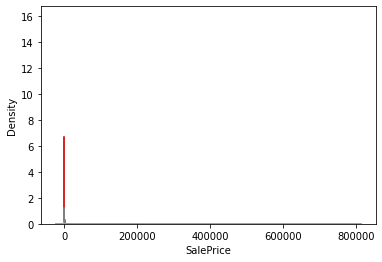

In [19]:


# Before Cleaning Plots
EDA.plot_dist(data, "SalePrice")
EDA.plot_all_dist(data)

    # def plot_all_bar(df, target=""):
    #     print(f"Plotting all features.\nIt may take a while..", end="\n\n")
    #     plt.figure(figsize=(20, 10))
    #     plot_id = 321
    #     skipped_cols = []
    #     def _plot_one(df, col):
    #         try:
    #             plt.subplot(plot_id)
    #             sns.barplot(x = col, y = target, data = df)
    #         except: skipped_cols.append(col)

    #     for col in df.columns:
    #         _plot_one(df, col)
    #         plot_id += 1
        
    #     print(f"Few columns faced exception: {skipped_cols}")